In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from shallow.torch.flows import (
    AffineAutoregressiveFlow,
    AutoregressiveNeuralSplineFlow,
    CouplingNeuralSplineFlow,
    trainer,
    )
from shallow.torch.utils import count_parameters

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
data = np.load('./posteriors.pkl', allow_pickle=True)

In [4]:
len(data)

100

In [5]:
true = np.array([p.attrs['injection_parameters']['chirp_mass'] for p in data])

In [6]:
true.shape

(100,)

In [7]:
posteriors = [np.array(p['chirp_mass']) for p in data]

In [8]:
n = min(p.size for p in posteriors)

In [9]:
n

462

In [10]:
rec = np.array([np.random.choice(p, n, replace=False) for p in posteriors])

In [11]:
rec.shape

(100, 462)

In [12]:
n_train = 90
idxs = np.arange(rec.shape[0])
np.random.shuffle(idxs)
train = idxs[:n_train]
valid = idxs[n_train:]

In [13]:
c = np.repeat(true[:, None], rec.shape[1], axis=1)

In [14]:
c.shape

(100, 462)

In [15]:
x_train = rec[train]
c_train = c[train]
x_valid = rec[valid]
c_valid = c[valid]

In [16]:
x_train.shape, c_train.shape, x_valid.shape, c_valid.shape

((90, 462), (90, 462), (10, 462), (10, 462))

In [17]:
x_train, c_train, x_valid, c_valid = map(
    lambda x: torch.as_tensor(np.concatenate(x)[:, None], dtype=torch.float32),
    (x_train, c_train, x_valid, c_valid),
    )

In [18]:
x_train.shape, c_train.shape, x_valid.shape, c_valid.shape

(torch.Size([41580, 1]),
 torch.Size([41580, 1]),
 torch.Size([4620, 1]),
 torch.Size([4620, 1]))

In [64]:
flow = AffineAutoregressiveFlow(
    inputs=x_train.shape[1],
    contexts=c_train.shape[1],
    bounds=[[0, None]],
    norm_inputs=x_train,
    norm_contexts=c_train,
    transforms=5,
    residual=False,
    blocks=2,
    hidden=10,
    activation='elu',
    dropout=0.0,
    batchnorm_within=False,
    batchnorm_between=True,
    permutation=None,
    linear=None,
    embedding=None,
    distribution=None,
    mask=False,
    )

In [65]:
# flow = AutoregressiveNeuralSplineFlow(
#     inputs=x_train.shape[1],
#     contexts=c_train.shape[1],
#     bounds=[[0, None]],
#     norm_inputs=x_train,
#     norm_contexts=c_train,
#     transforms=2,
#     residual=False,
#     blocks=1,
#     hidden=10,
#     activation='elu',
#     dropout=0.0,
#     batchnorm_within=False,
#     batchnorm_between=True,
#     permutation=None,
#     linear=None,
#     embedding=None,
#     distribution=None,
#     mask='mid',
#     bins=5,
#     tails='linear',
#     bound=5.0,
#     )

In [66]:
# flow = CouplingNeuralSplineFlow(
#     inputs=x_train.shape[1],
#     contexts=c_train.shape[1],
#     bounds=[[0, None]],
#     norm_inputs=x_train,
#     norm_contexts=c_train,
#     transforms=1,
#     residual=False,
#     blocks=1,
#     hidden=10,
#     activation='elu',
#     dropout=0.0,
#     batchnorm_within=False,
#     batchnorm_between=True,
#     permutation=None,
#     linear=None,
#     embedding=None,
#     distribution=None,
#     mask='mid',
#     bins=5,
#     tails='linear',
#     bound=5.0,
#     )

In [67]:
count_parameters(flow)

1420

In [68]:
flow, losses = trainer(
    flow,
    x_train,
    contexts=c_train,
    inputs_valid=x_valid,
    contexts_valid=c_valid,
    loss=None,
    optimizer='adam',
    learning_rate=1e-3,
    weight_decay=0,
    epochs=1_000,
    batch_size=100,
    batch_size_valid='train',
    shuffle=True,
    reduce=10,
    stop=20,
    stop_if_inf=True,
    verbose=False,
    save=None,
    seed=None,
    )

  6%|███▋                                                       | 63/1000 [04:38<1:09:01,  4.42s/it]


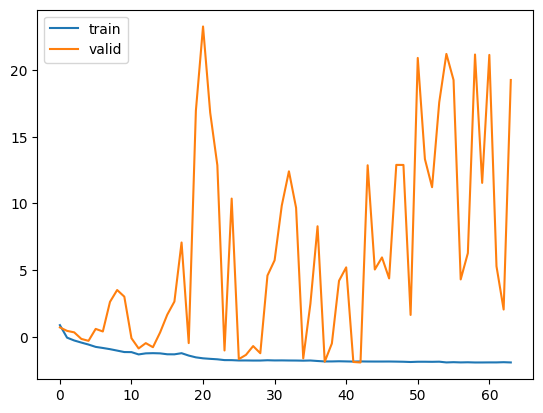

In [69]:
for key, val in losses.items():
    plt.plot(val, label=key)
plt.legend();

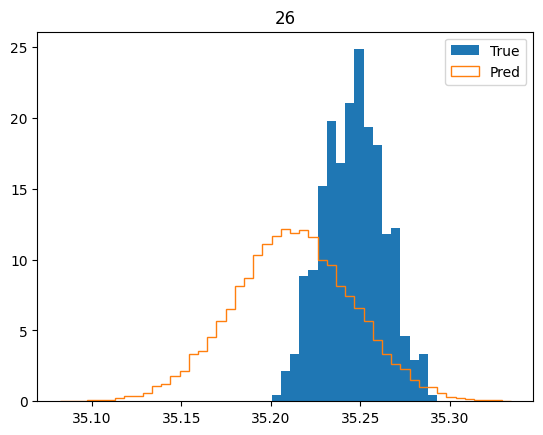

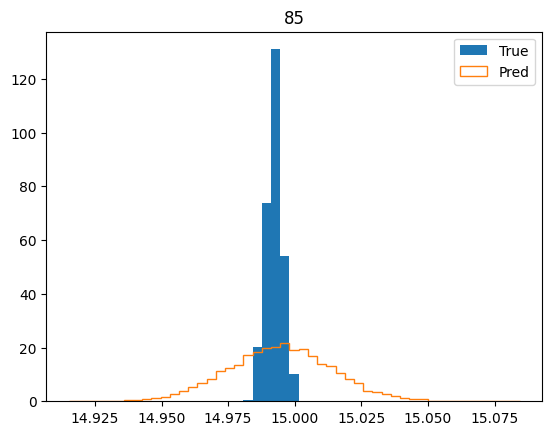

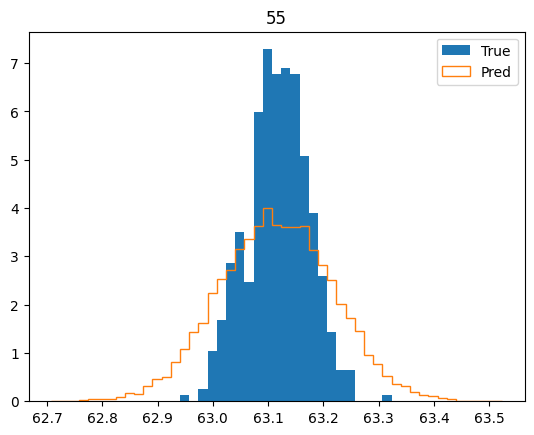

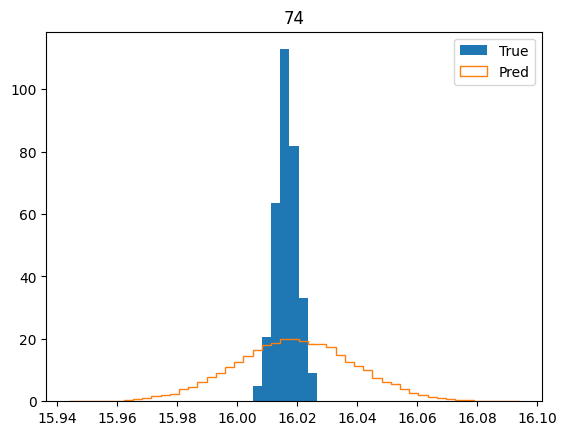

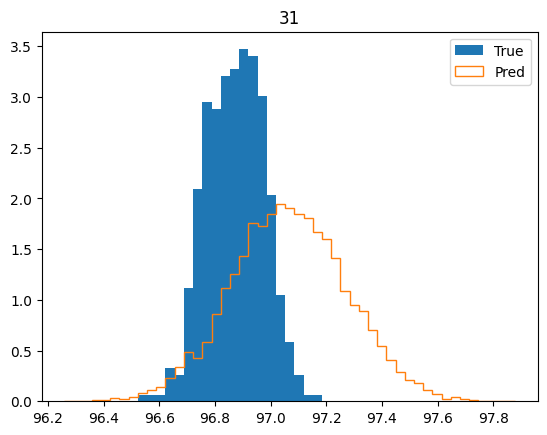

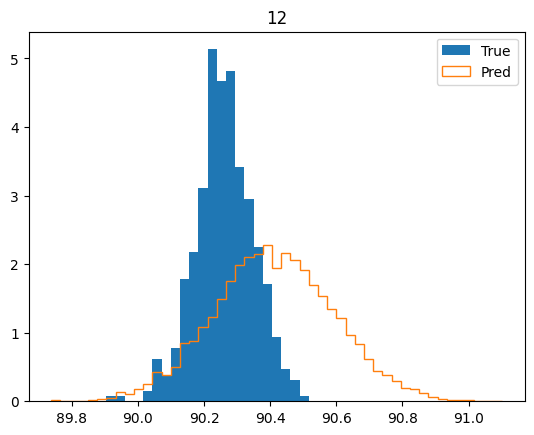

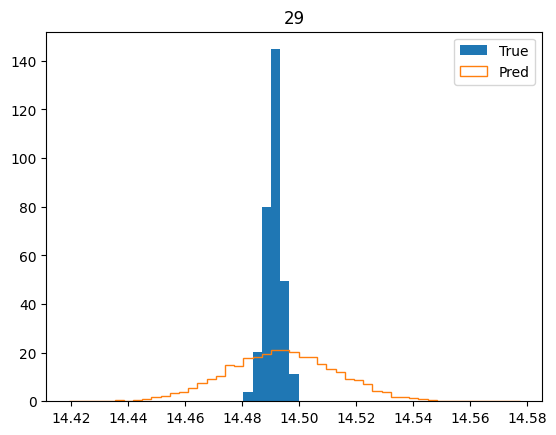

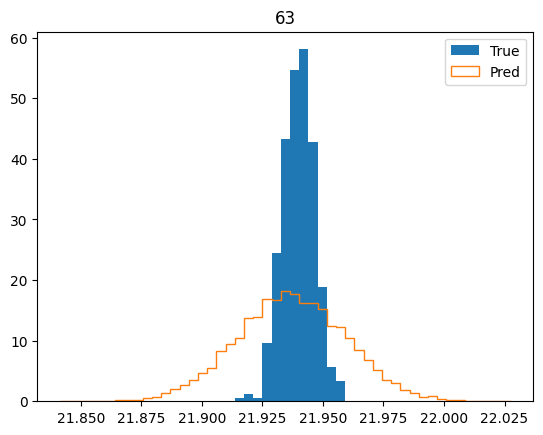

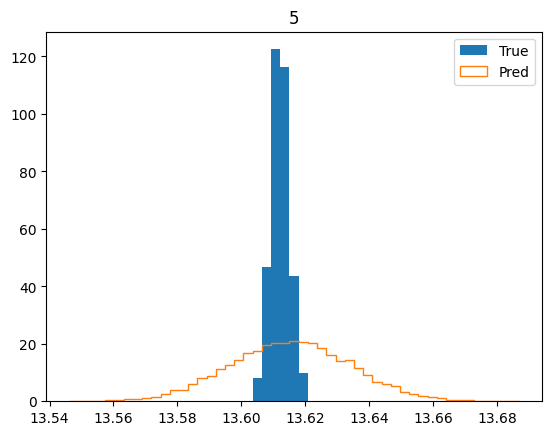

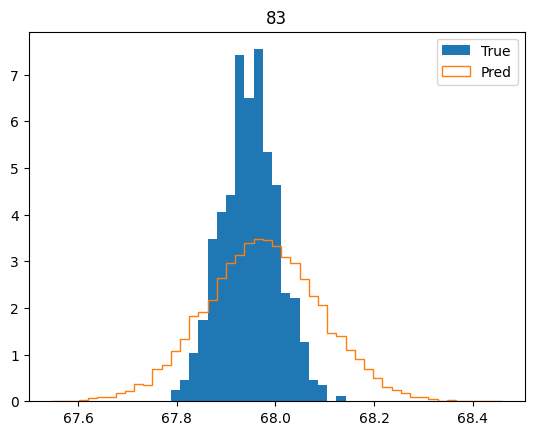

In [70]:
for idx in valid:

    with torch.inference_mode():
        pred = flow.sample(
            10_000,
            torch.as_tensor(true[[idx]][None], dtype=torch.float32),
            ).squeeze().numpy()
    
    bins = np.linspace(
        min(rec[idx].min(), pred.min()),
        max(rec[idx].max(), pred.max()),
        50,
        )
        
    plt.hist(rec[idx], bins=bins, density=True, label='True')
    plt.hist(pred, bins=bins, density=True, histtype='step', label='Pred')
    plt.legend()
    plt.title(idx)

    plt.show()

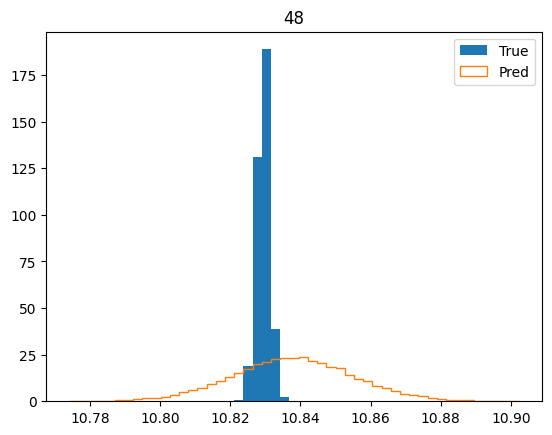

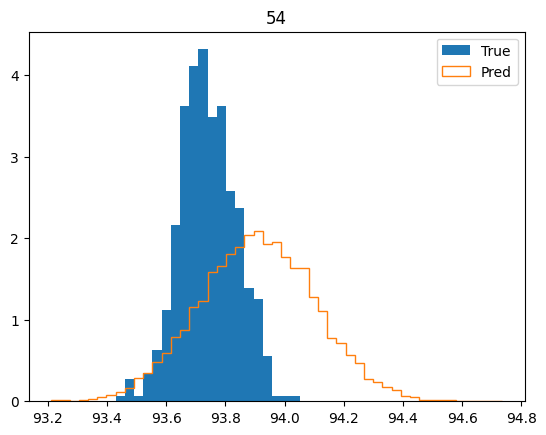

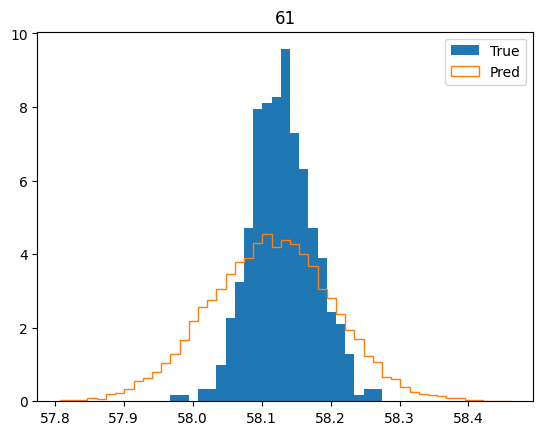

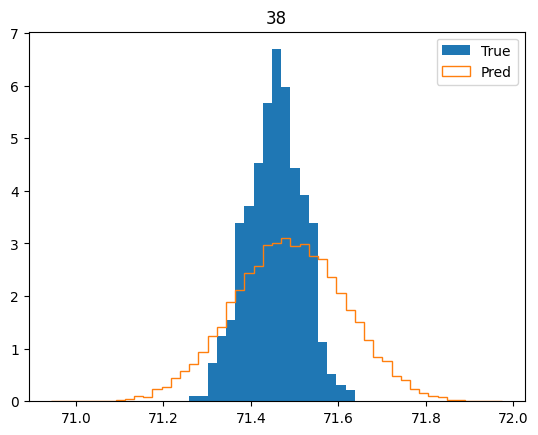

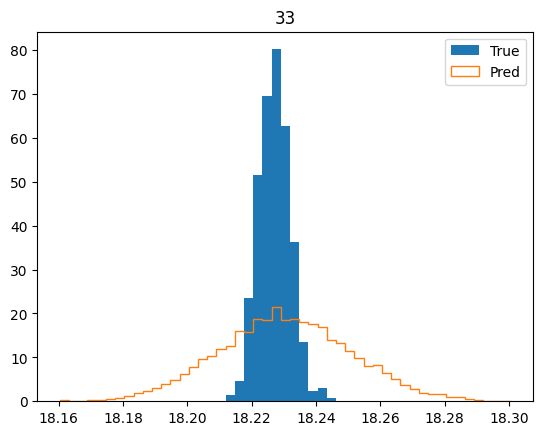

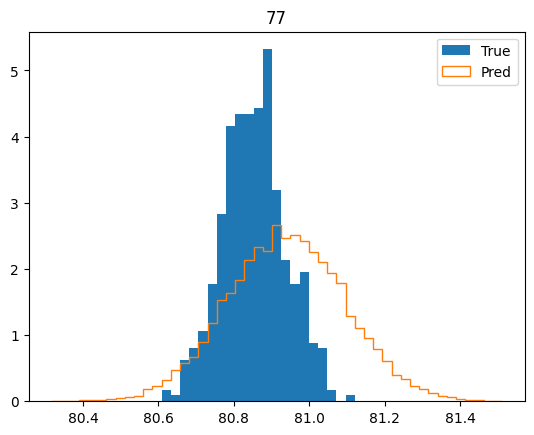

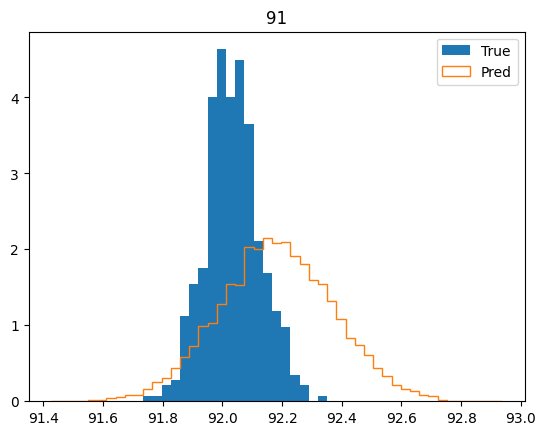

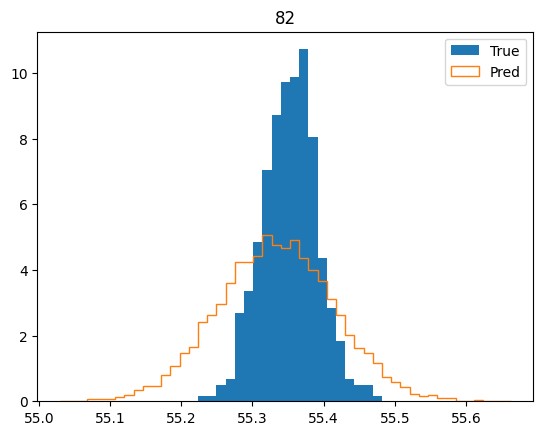

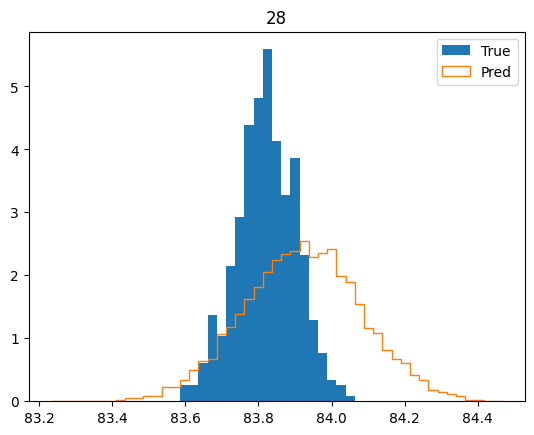

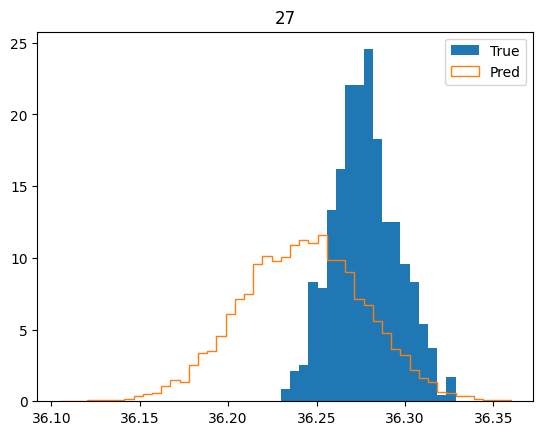

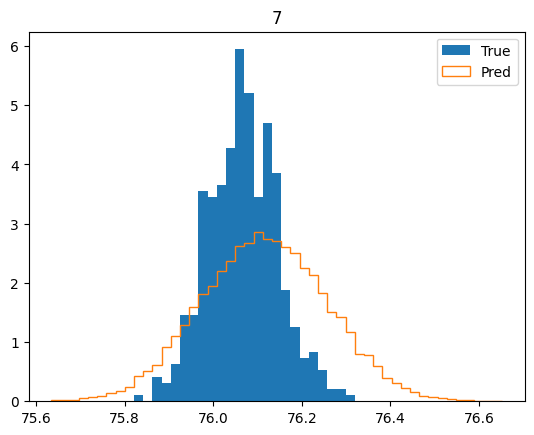

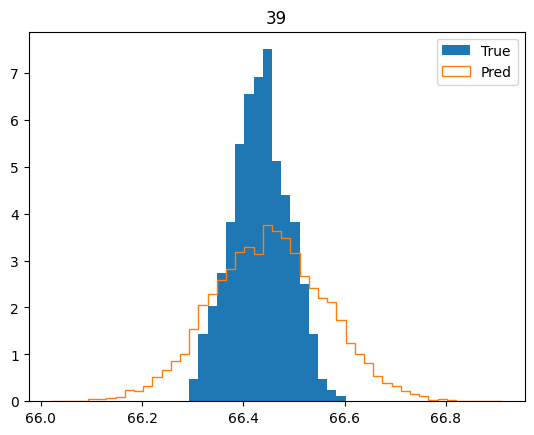

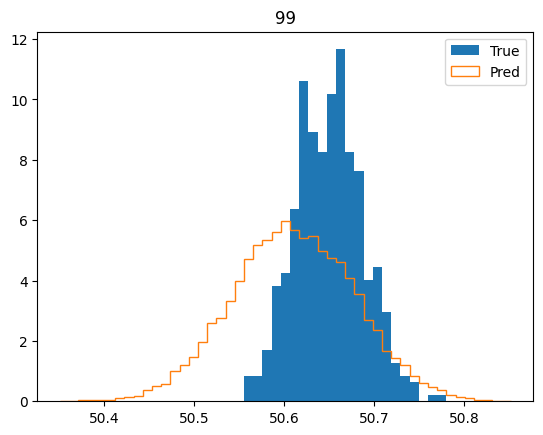

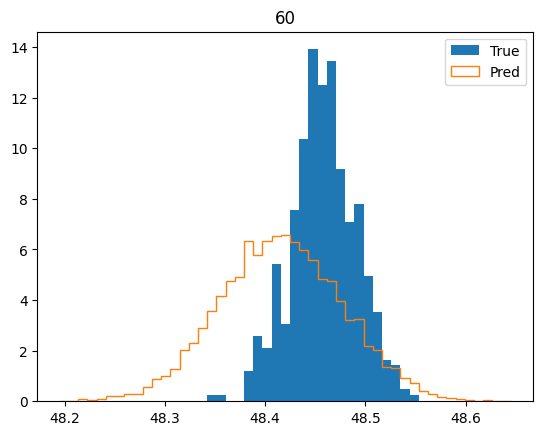

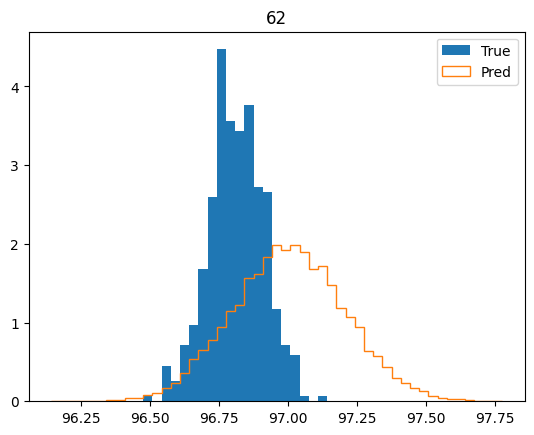

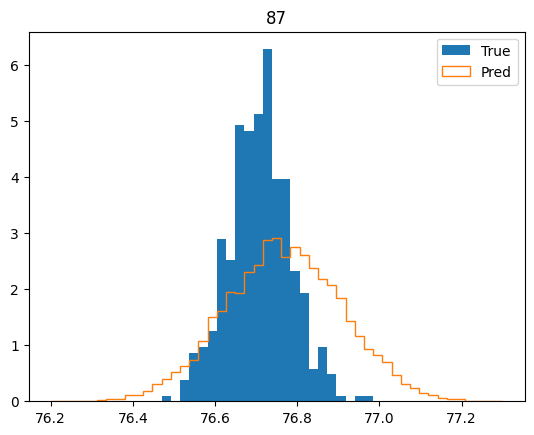

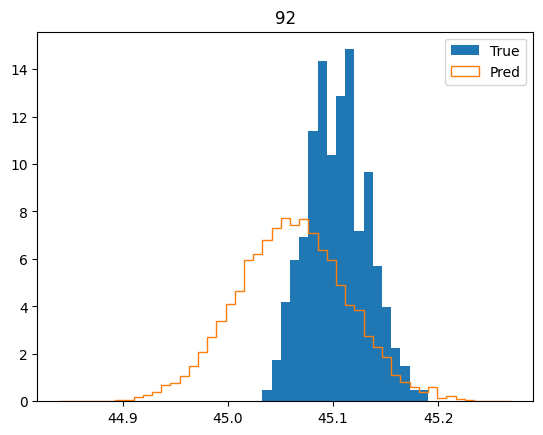

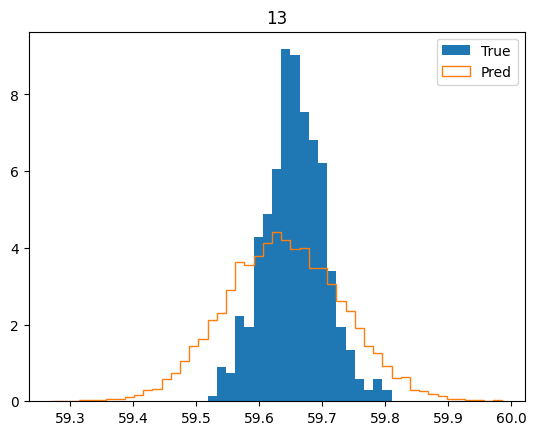

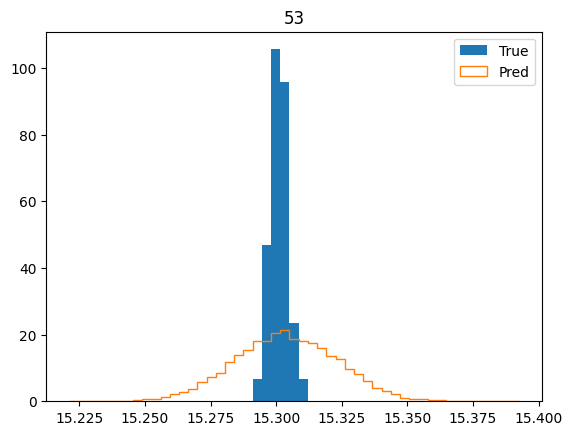

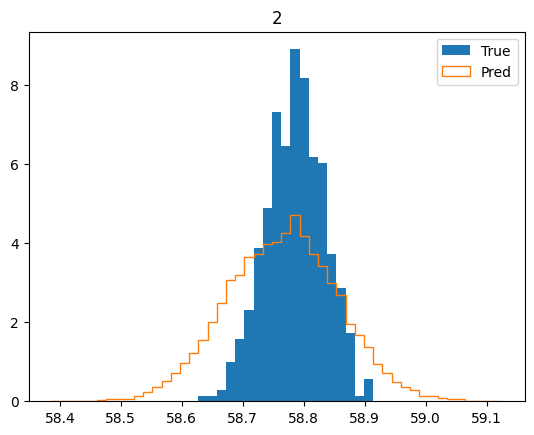

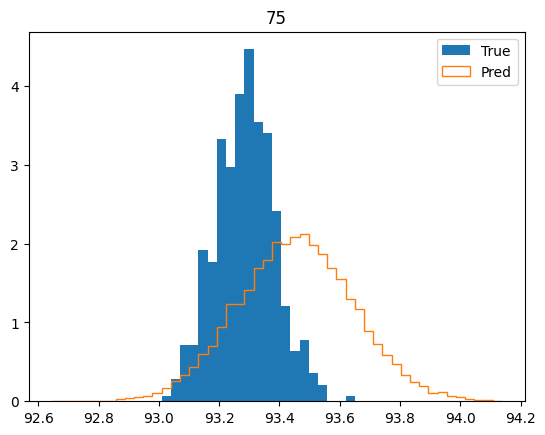

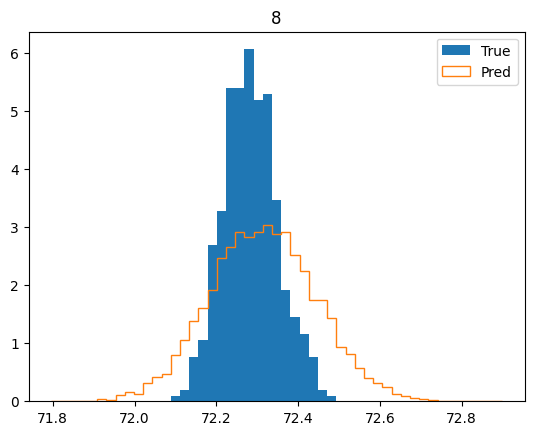

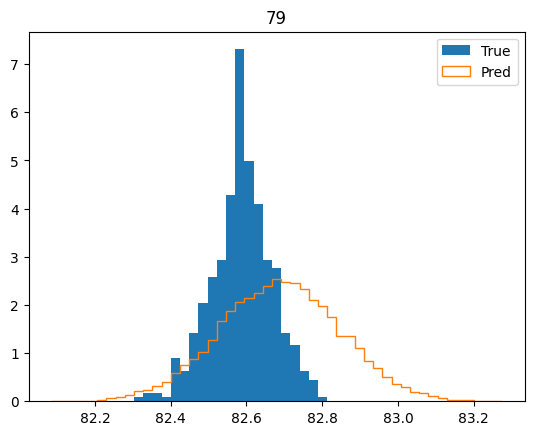

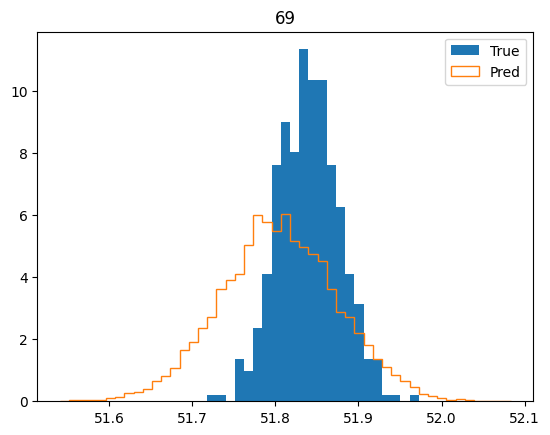

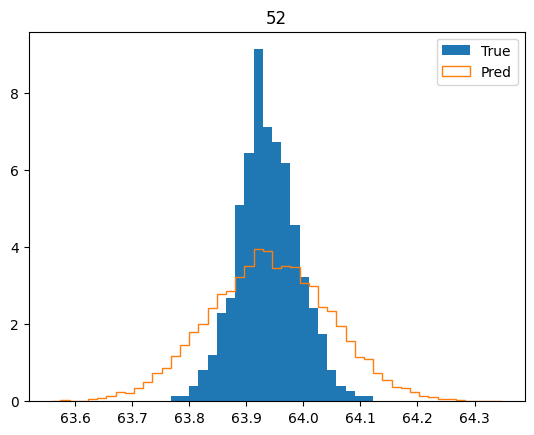

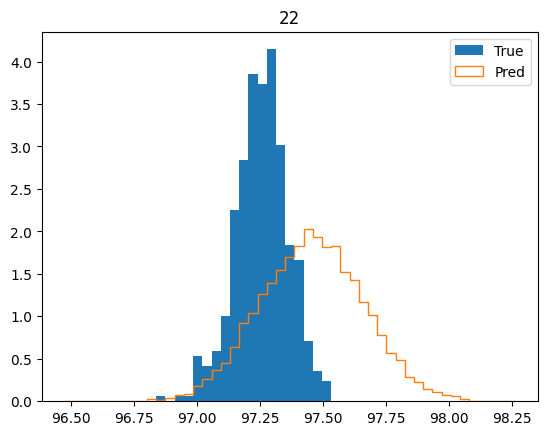

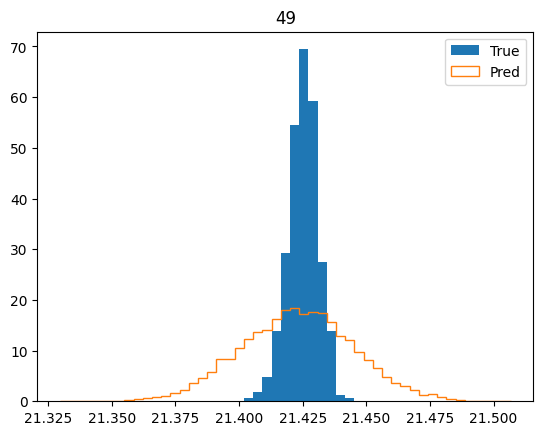

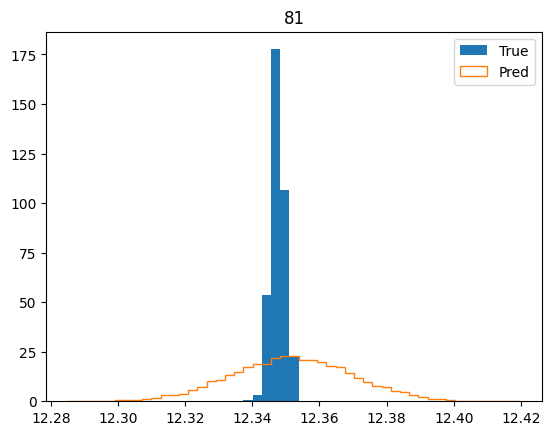

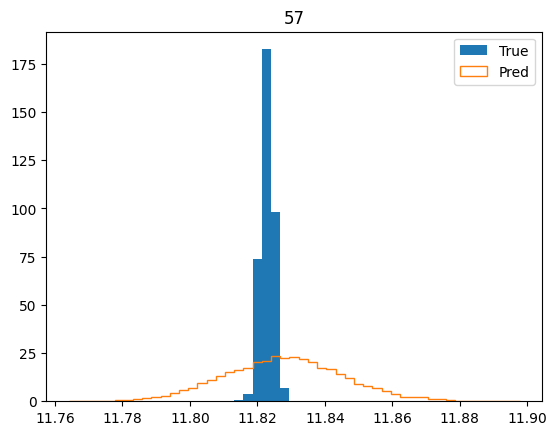

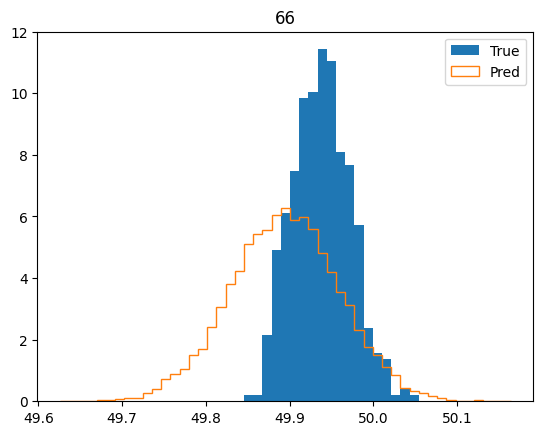

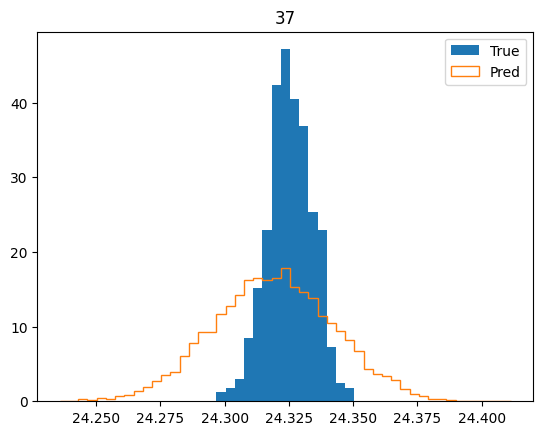

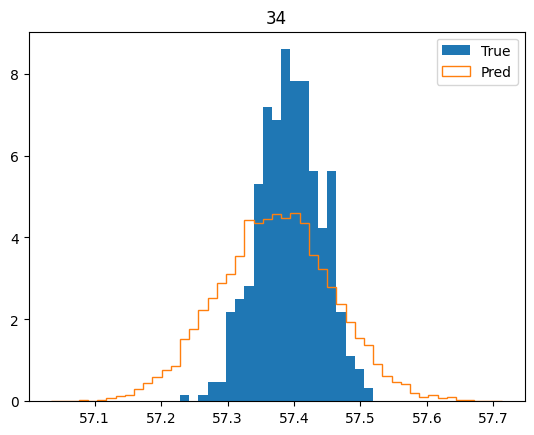

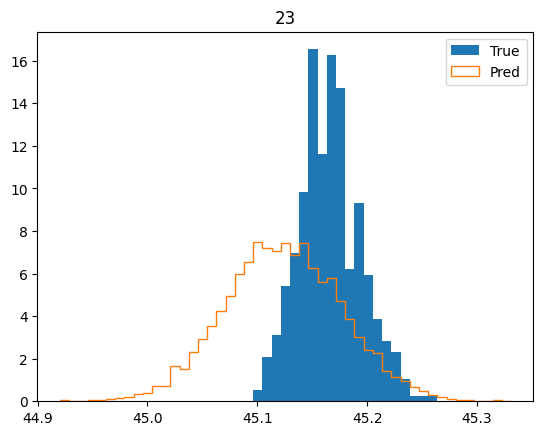

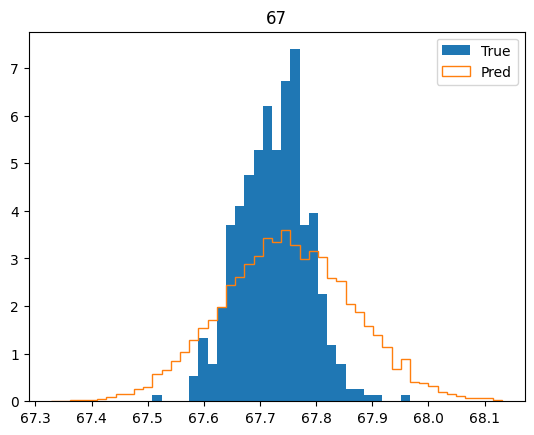

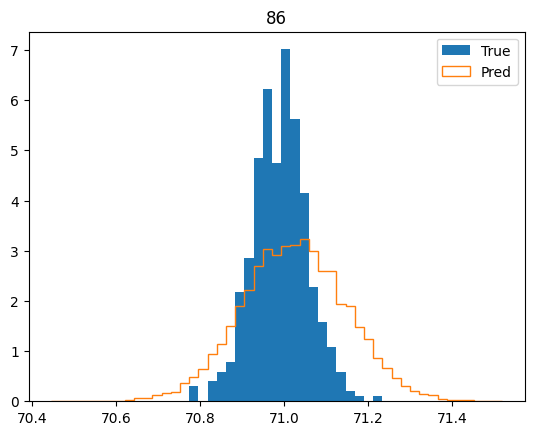

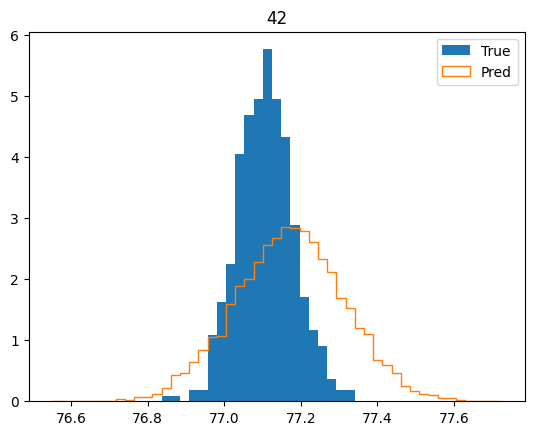

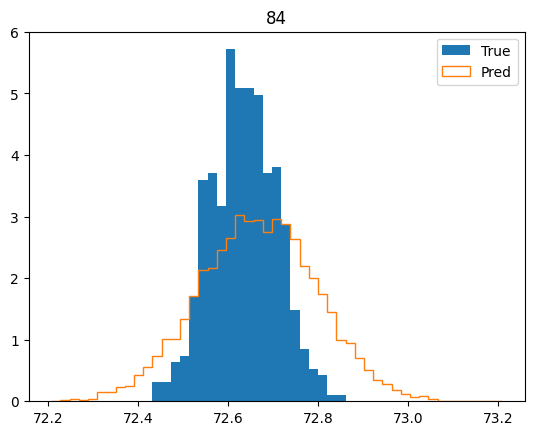

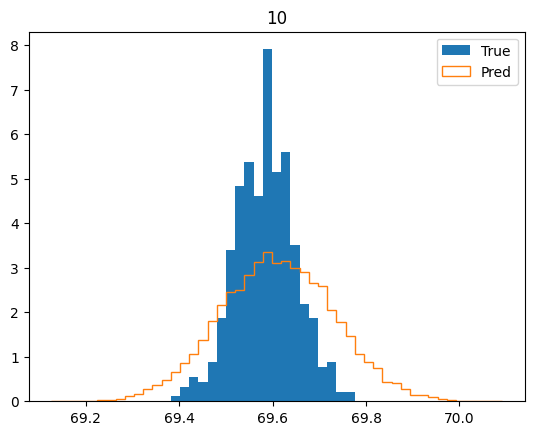

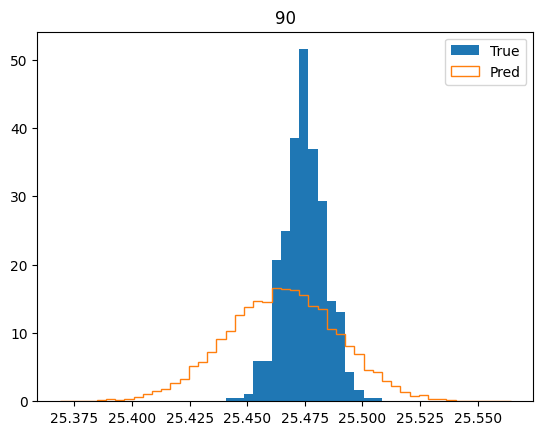

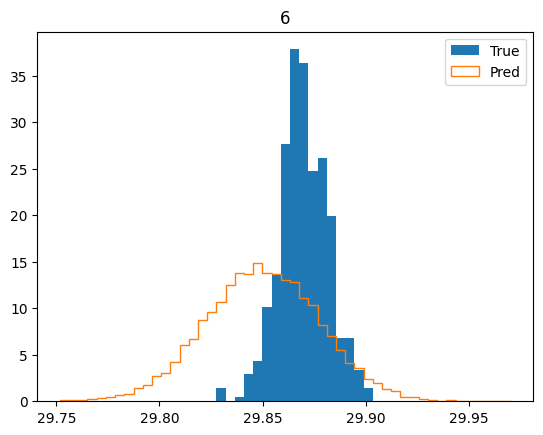

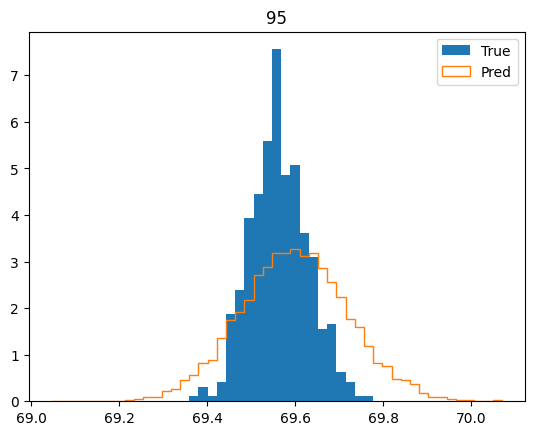

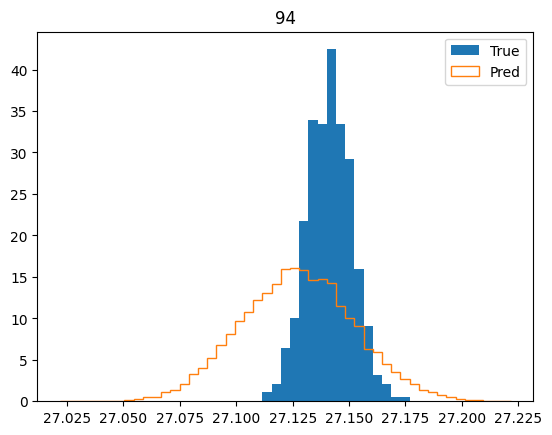

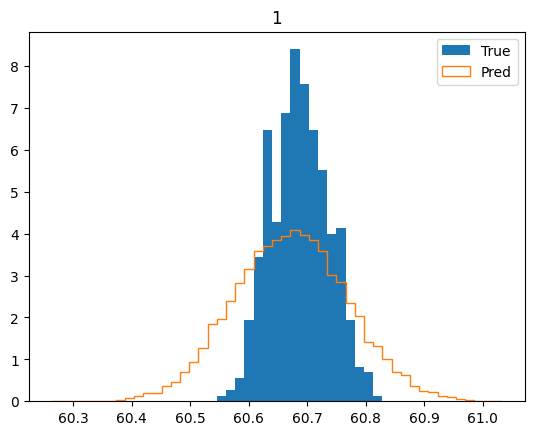

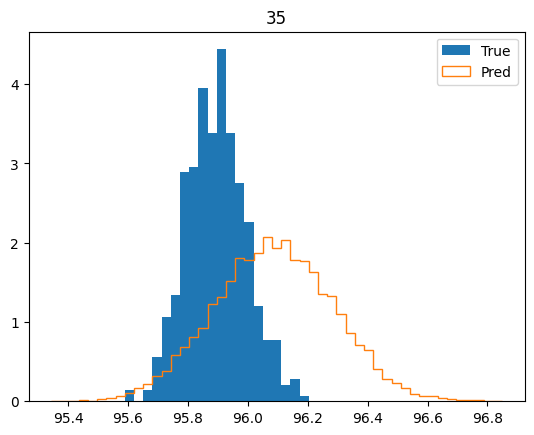

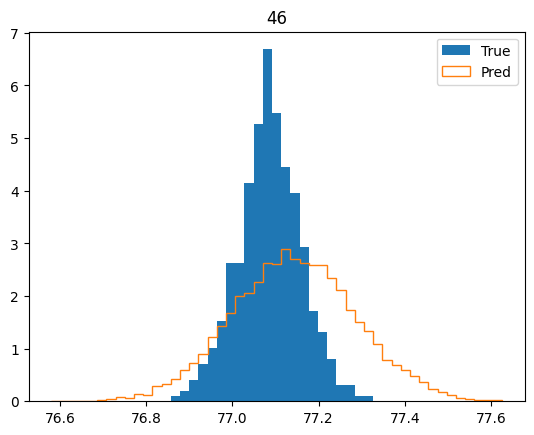

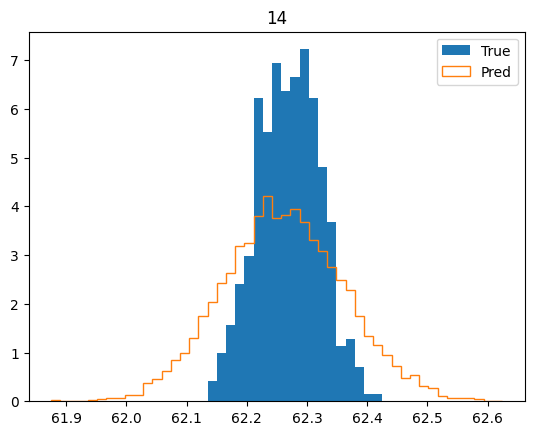

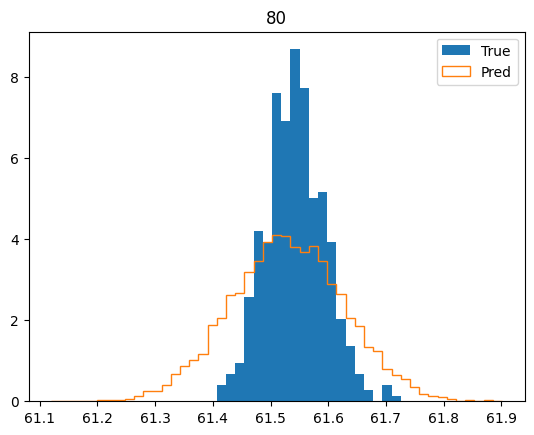

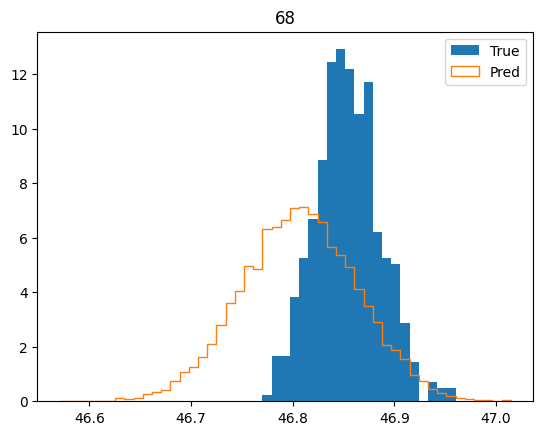

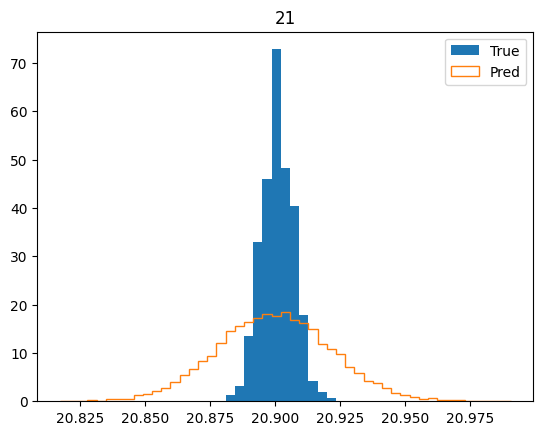

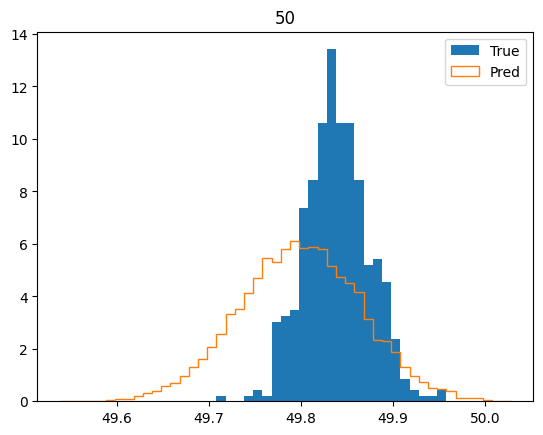

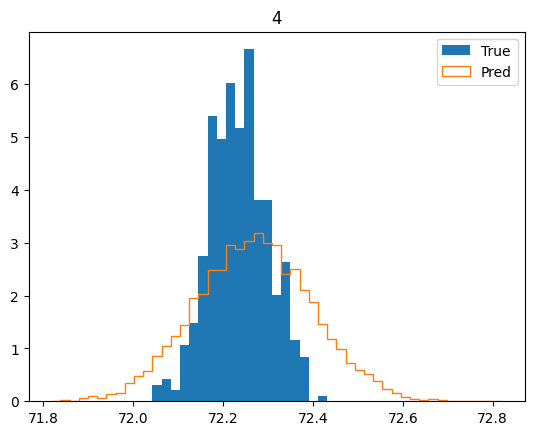

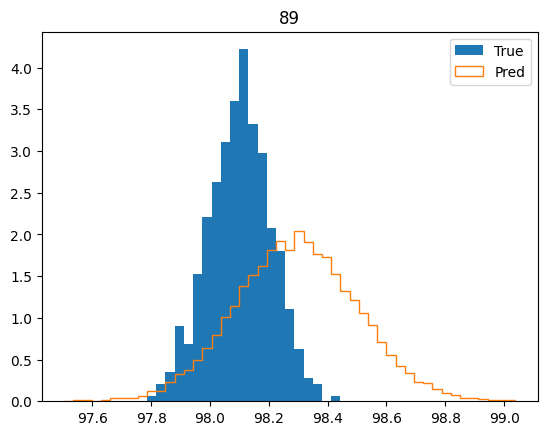

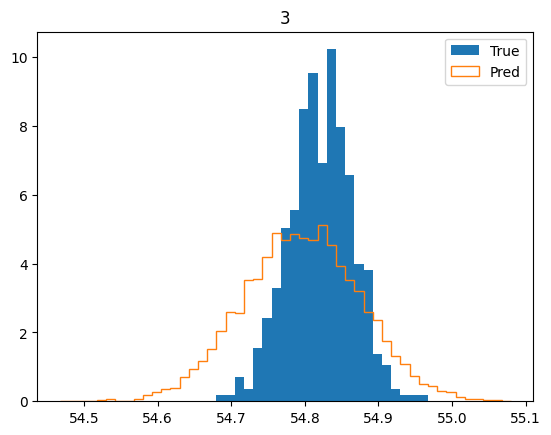

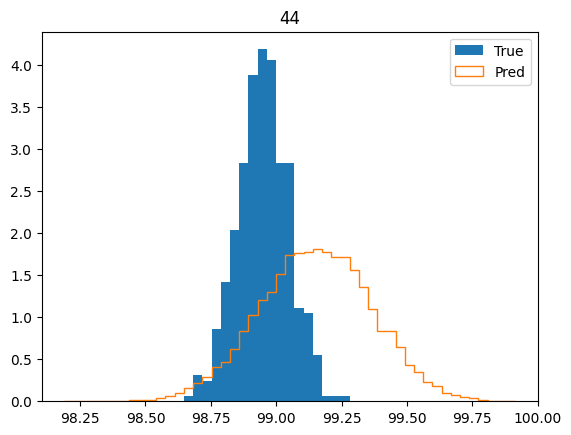

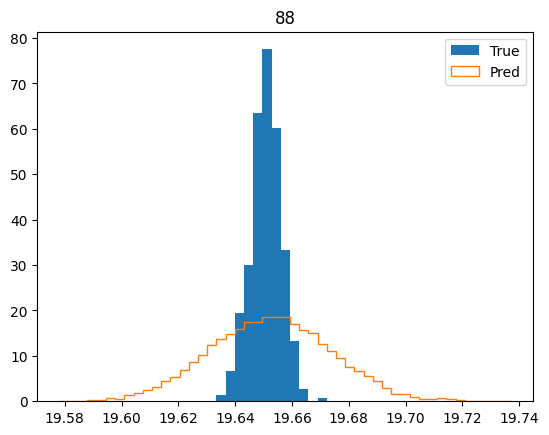

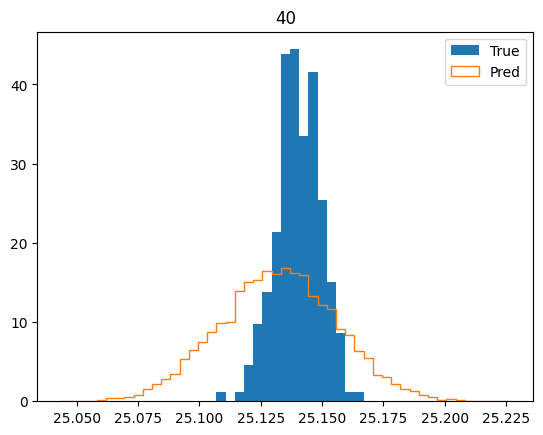

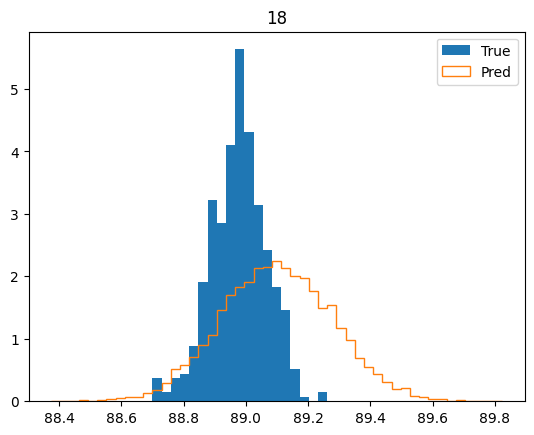

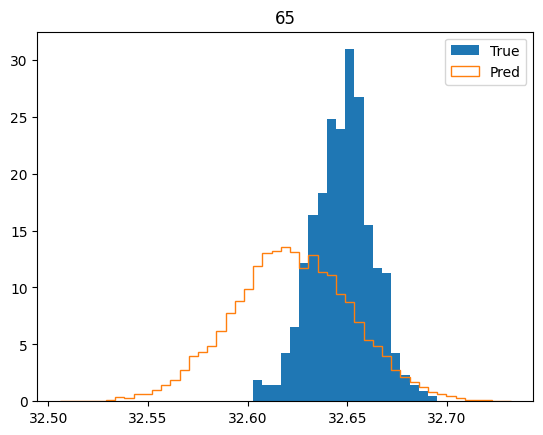

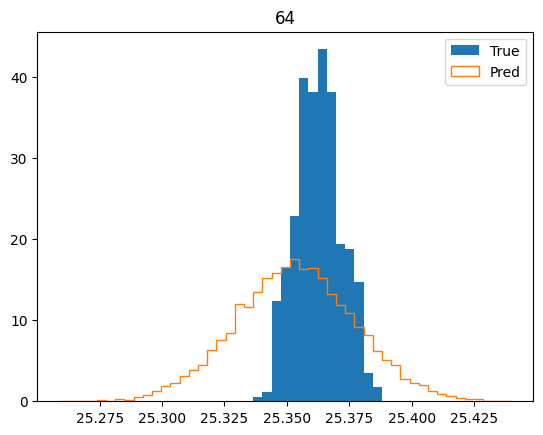

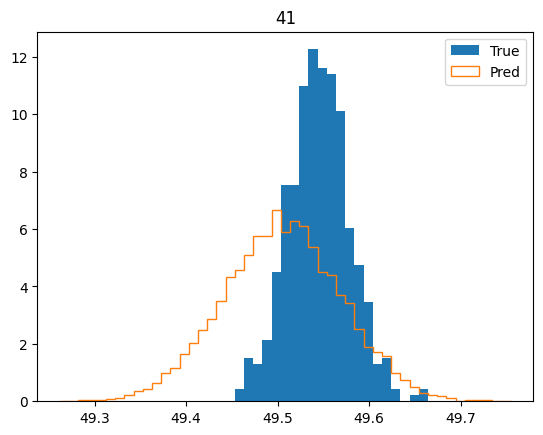

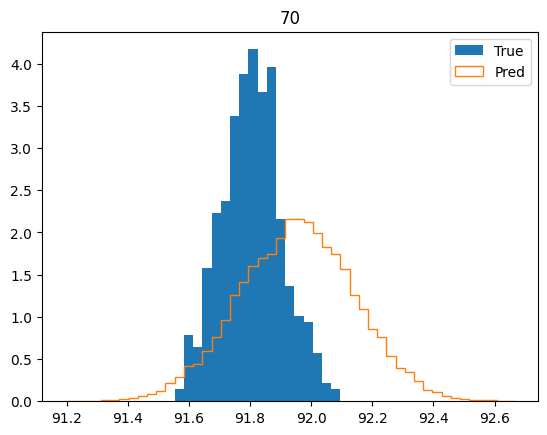

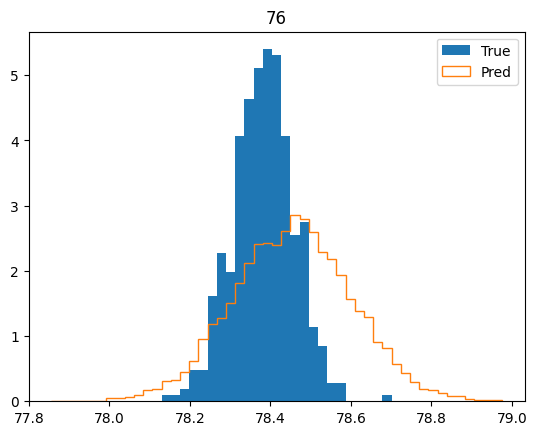

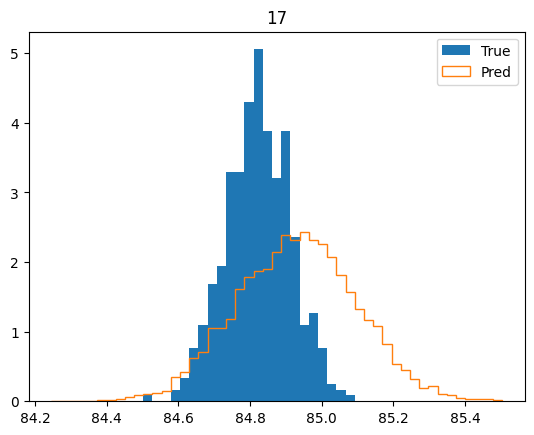

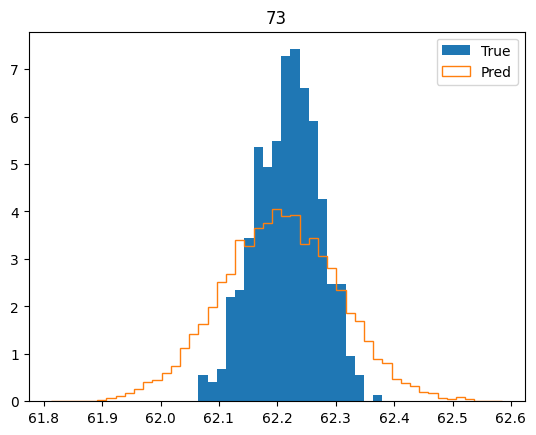

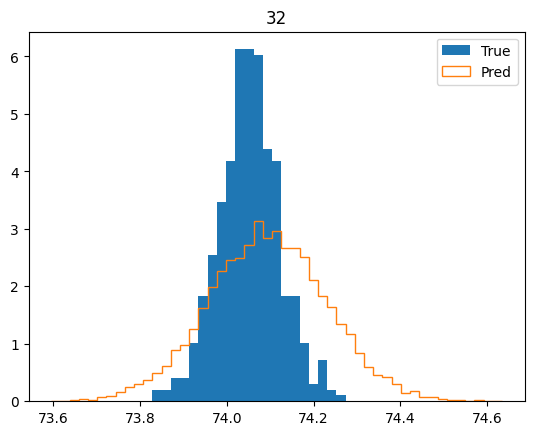

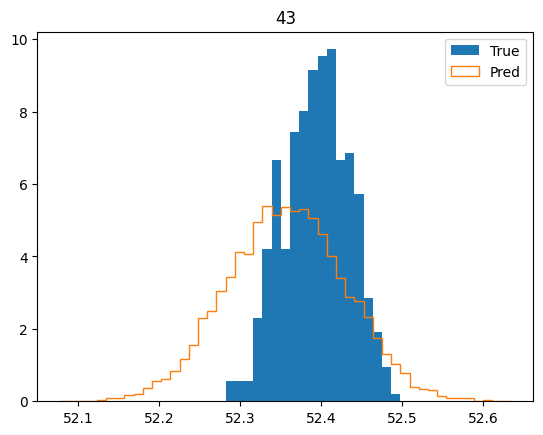

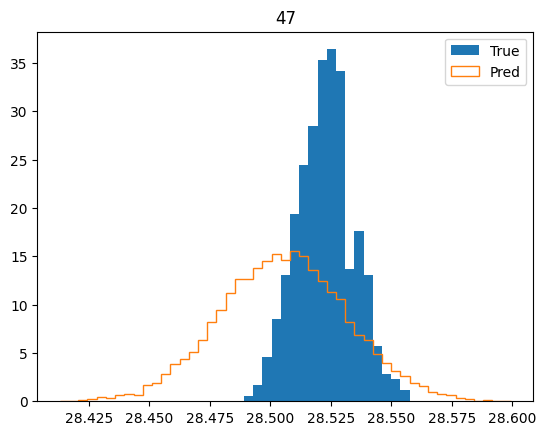

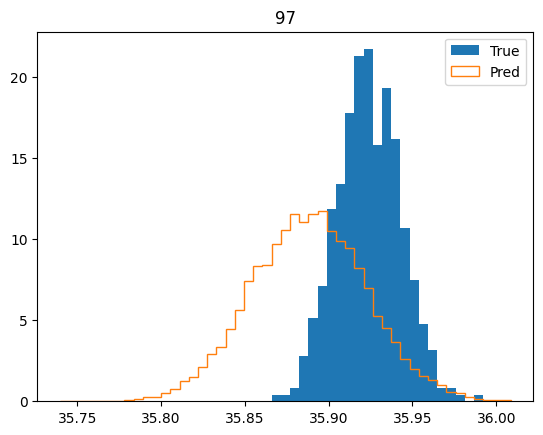

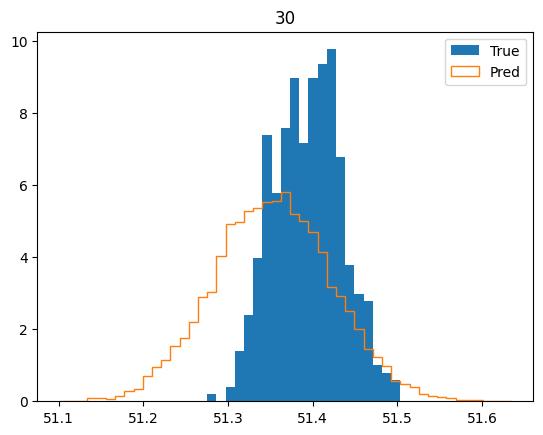

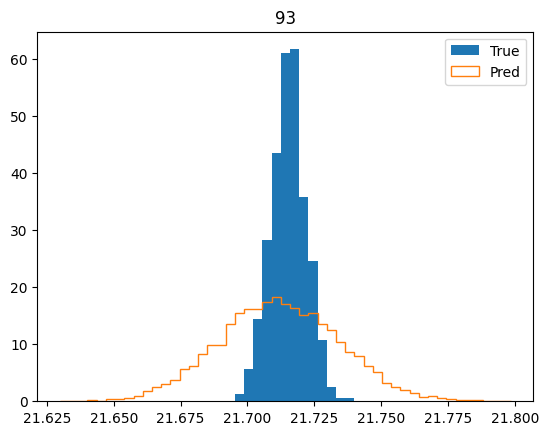

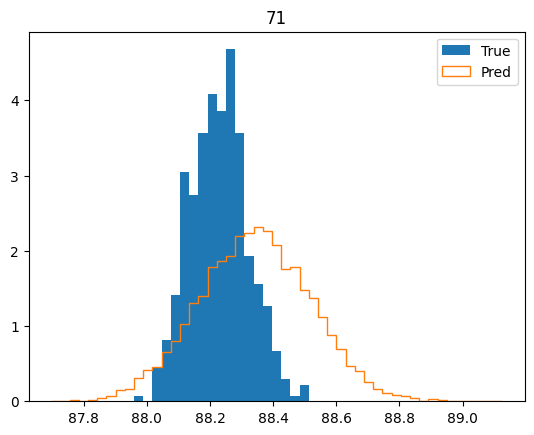

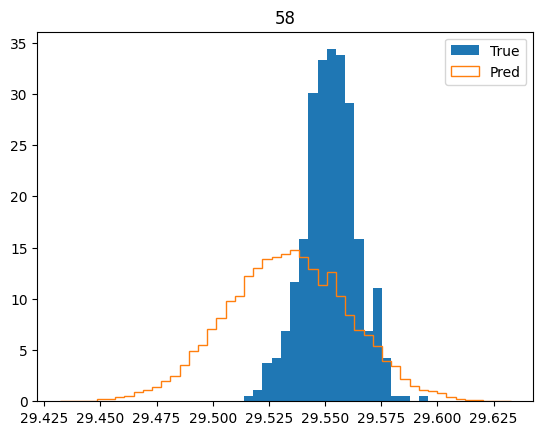

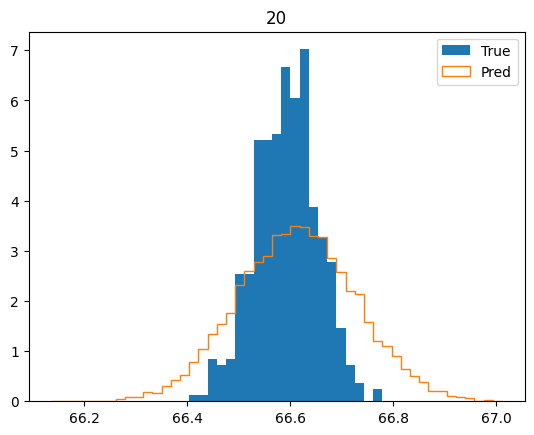

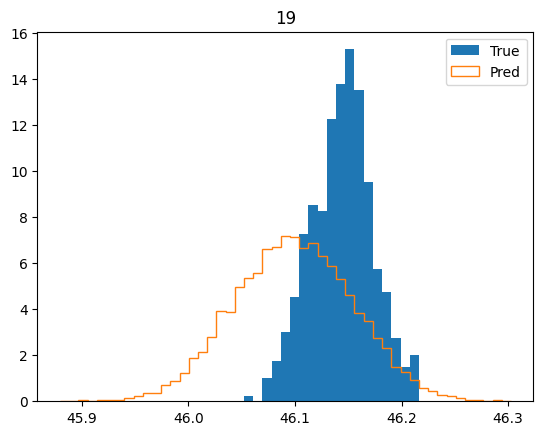

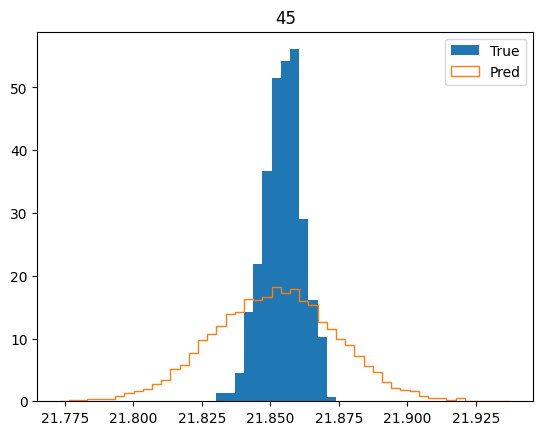

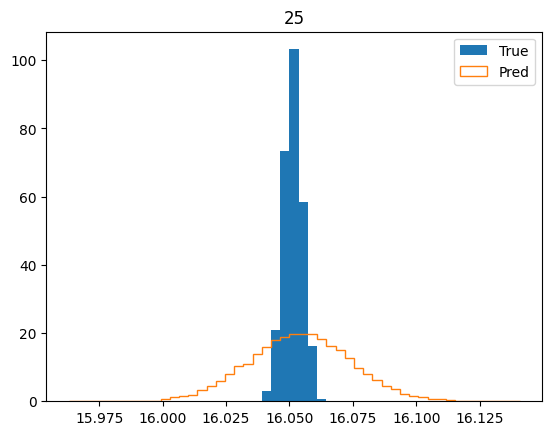

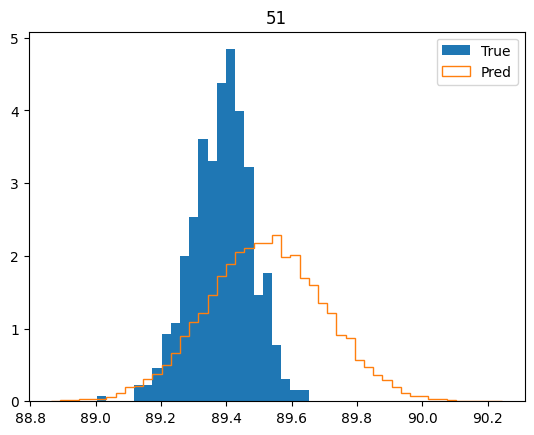

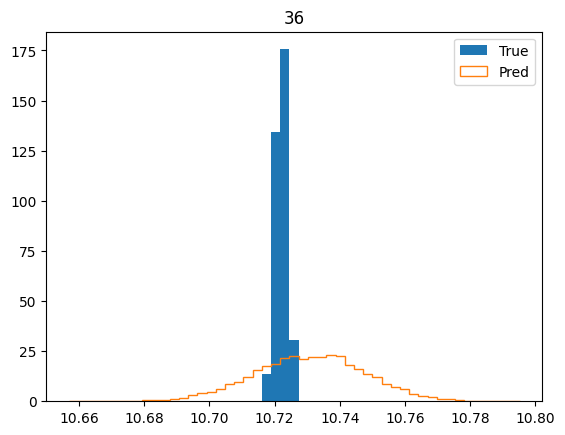

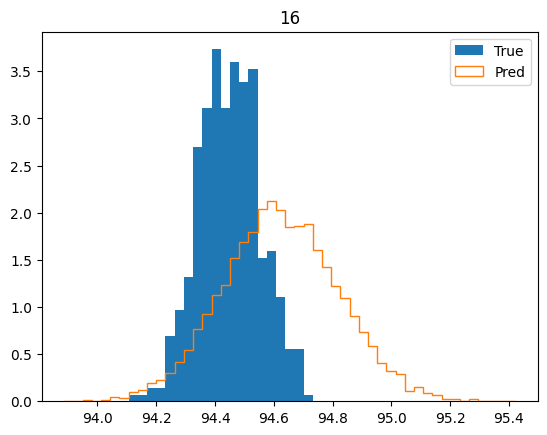

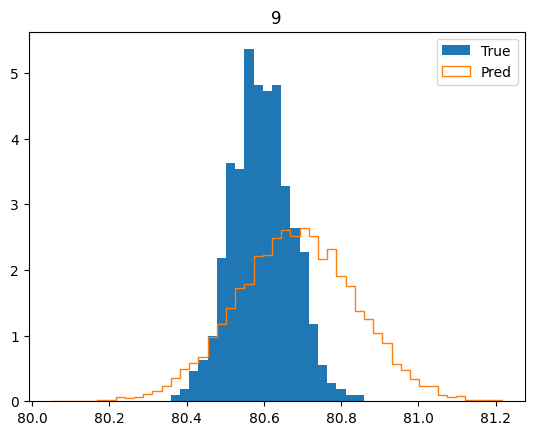

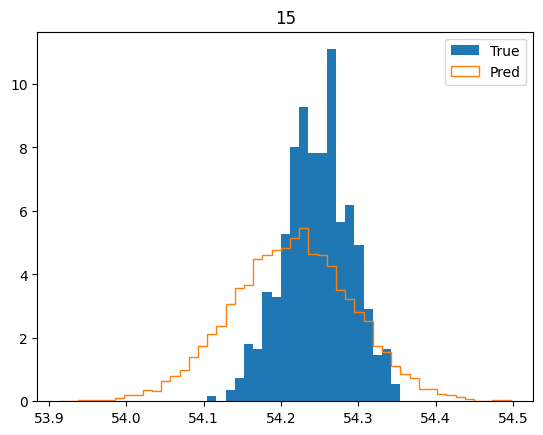

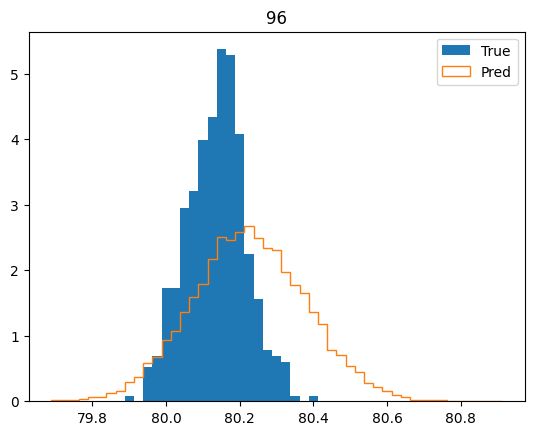

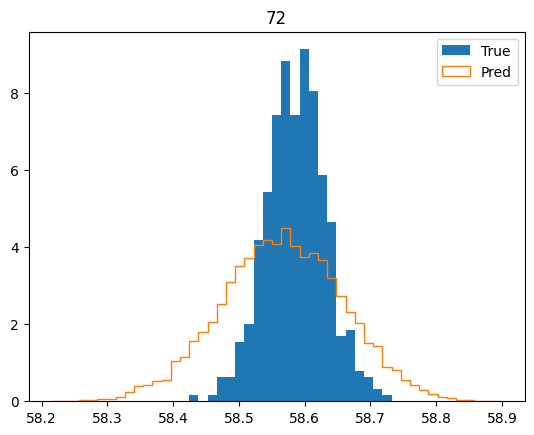

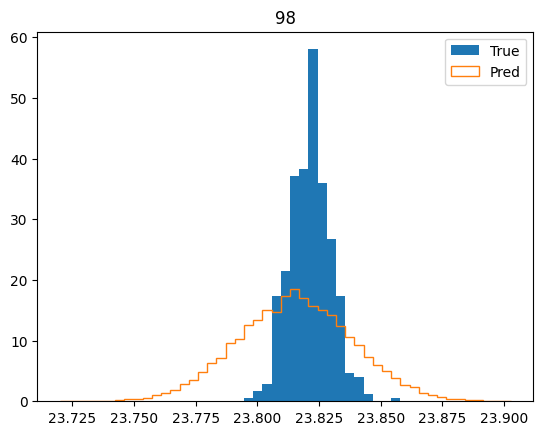

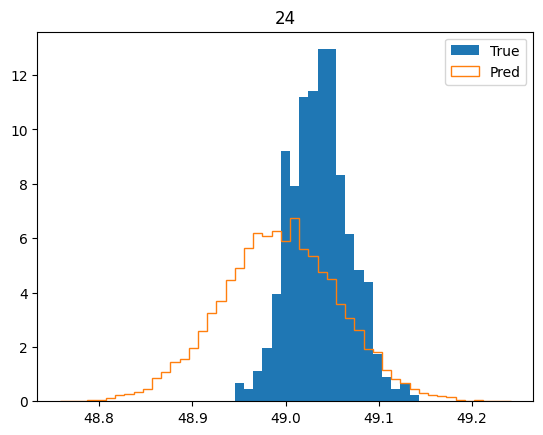

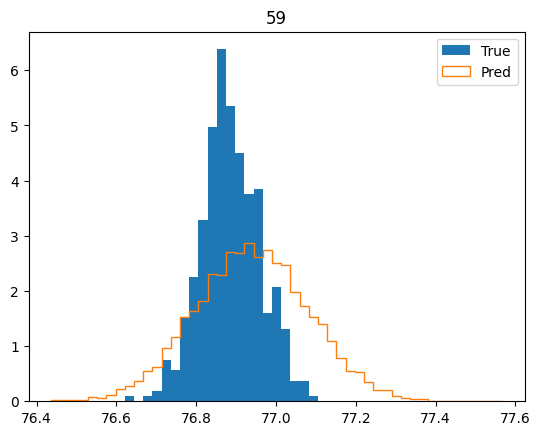

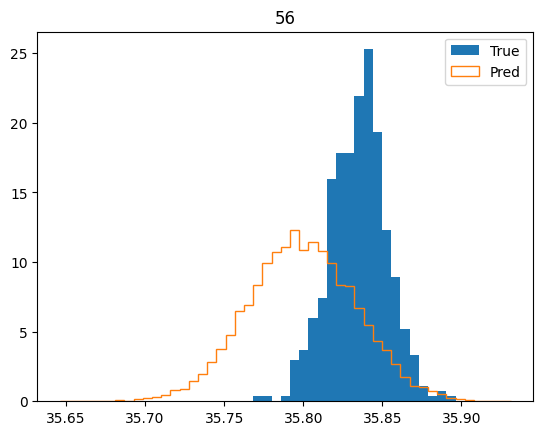

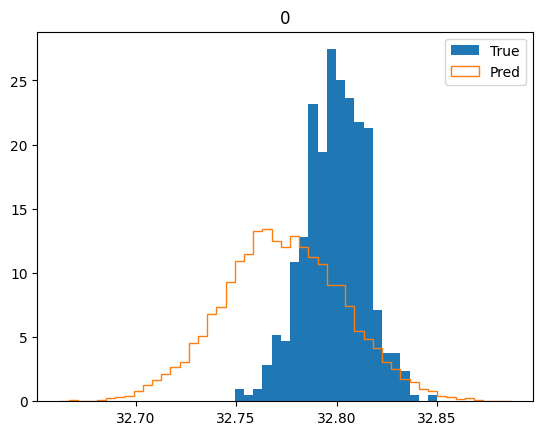

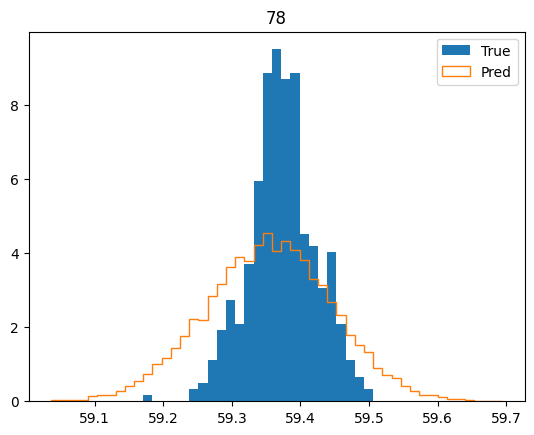

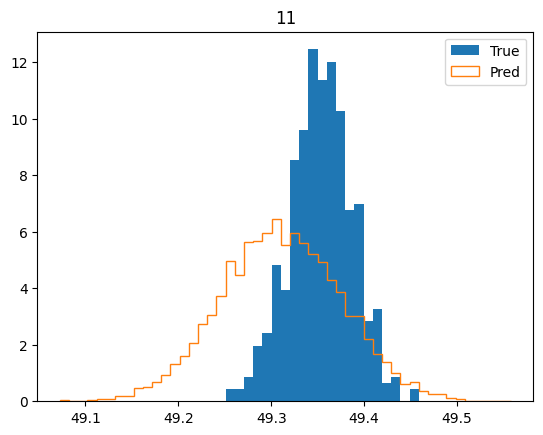

In [71]:
for idx in train:

    with torch.inference_mode():
        pred = flow.sample(
            10_000,
            torch.as_tensor(true[[idx]][None], dtype=torch.float32),
            ).squeeze().numpy()
    
    bins = np.linspace(
        min(rec[idx].min(), pred.min()),
        max(rec[idx].max(), pred.max()),
        50,
        )
        
    plt.hist(rec[idx], bins=bins, density=True, label='True')
    plt.hist(pred, bins=bins, density=True, histtype='step', label='Pred')
    plt.legend()
    plt.title(idx)

    plt.show()